In [1]:
# path library
from pathlib import Path

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# data manipulation
import pandas as pd

# machine learning


In [28]:
# random seed to be used throughout
random_seed = 6

# sample size of the data to use for EDA
sample_size = 20000

In [3]:
# path to processed data
DATA_PATH = Path.cwd().resolve().parents[0] / "data" / "processed" / "processed_data.csv"

In [4]:
df = pd.read_csv(DATA_PATH)

# The data at a glance

In [5]:
df.head()

,month,time,day,hospital,m_age,m_us_born,m_edu,num_of_prenatals,WIC,smoker,...,eclampsia,preterm_births,infert_treatment,prev_c_section,sti,induction,steroids,antibiotics,anesthesia,c_section
0,1,5.016667,2,1,30,1,3,8,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,5.150000,3,1,28,1,6,13,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,5.416666,3,1,41,1,6,11,0,0,...,0,1,0,1,0,0,0,1,1,0
3,1,19.166666,2,0,29,1,4,10,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,22.683332,2,1,28,1,6,13,0,0,...,0,1,0,0,0,0,0,0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3388302 entries, 0 to 3388301
Data columns (total 25 columns):
 #   Column             Dtype  
---  ------             -----  
 0   month              int64  
 1   time               float64
 2   day                int64  
 3   hospital           int64  
 4   m_age              int64  
 5   m_us_born          int64  
 6   m_edu              int64  
 7   num_of_prenatals   int64  
 8   WIC                int64  
 9   smoker             int64  
 10  m_bmi              float64
 11  pre_diabetes       int64  
 12  gest_diabetes      int64  
 13  pre_hypertension   int64  
 14  gest_hypertension  int64  
 15  eclampsia          int64  
 16  preterm_births     int64  
 17  infert_treatment   int64  
 18  prev_c_section     int64  
 19  sti                int64  
 20  induction          int64  
 21  steroids           int64  
 22  antibiotics        int64  
 23  anesthesia         int64  
 24  c_section          int64  
dtypes: float64(2), int

In [7]:
# Downcast dtypes to optimize memory footprint
fcols = df.select_dtypes('float').columns
icols = df.select_dtypes('integer').columns

df[fcols] = df[fcols].apply(pd.to_numeric, downcast='float')
df[icols] = df[icols].apply(pd.to_numeric, downcast='integer')

# EDA

In [8]:
# We will split the columns into numeric and categorical for the analysis
df.columns

Index(['month', 'time', 'day', 'hospital', 'm_age', 'm_us_born', 'm_edu',
       'num_of_prenatals', 'WIC', 'smoker', 'm_bmi', 'pre_diabetes',
       'gest_diabetes', 'pre_hypertension', 'gest_hypertension', 'eclampsia',
       'preterm_births', 'infert_treatment', 'prev_c_section', 'sti',
       'induction', 'steroids', 'antibiotics', 'anesthesia', 'c_section'],
      dtype='object')

In [9]:
num_cols = ['month', 'time', 'day', 'm_age', 'm_edu', 'num_of_prenatals', 'm_bmi']
cat_cols = ['hospital', 'm_us_born','WIC', 'smoker', 'pre_diabetes',
            'gest_diabetes', 'pre_hypertension', 'gest_hypertension', 'eclampsia',
            'preterm_births', 'infert_treatment', 'prev_c_section', 'sti',
            'induction', 'steroids', 'antibiotics', 'anesthesia', 'c_section']

In [29]:
# We will only use a sample of the data while performing EDA
# to improve compute time.
df_sample = df.sample(sample_size, random_state=random_seed)

In [30]:
# play around with the 'multiple' parameter:
# dodge, stack, fill

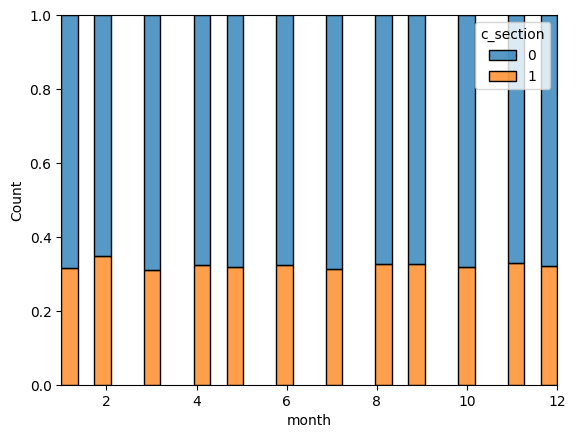

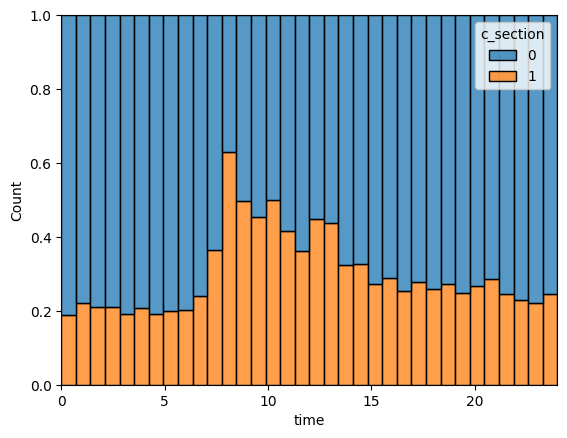

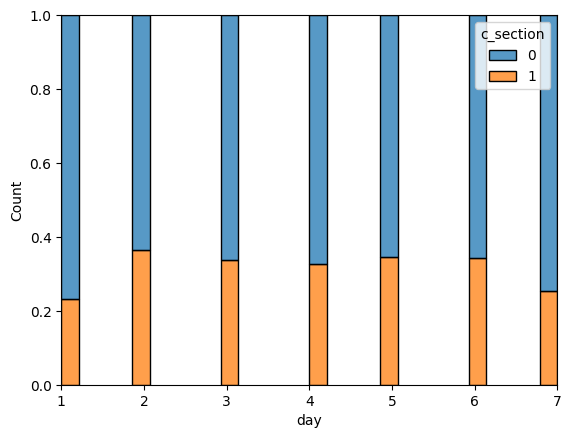

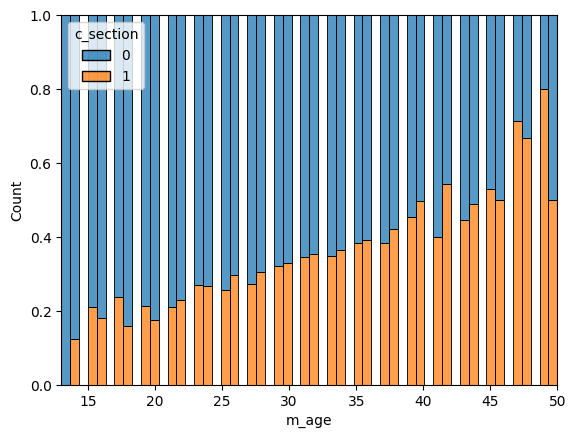

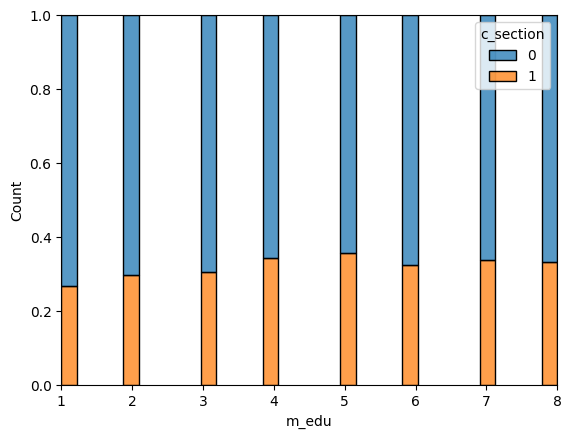

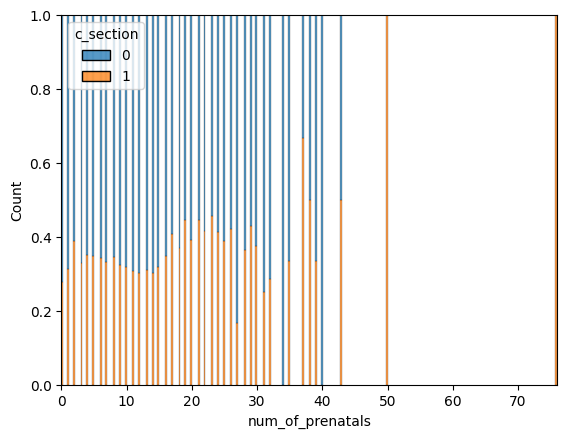

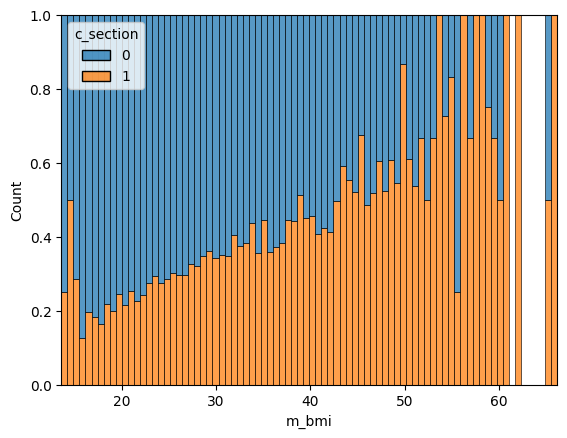

In [31]:
for i,col in enumerate(num_cols):
    plt.figure(i)
    sns.histplot(df_sample, x=col, hue='c_section', multiple='fill')

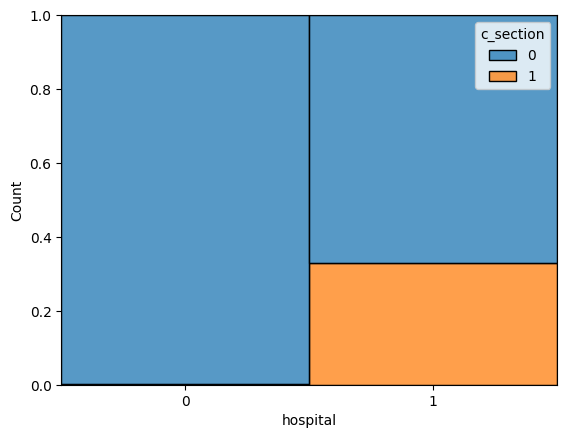

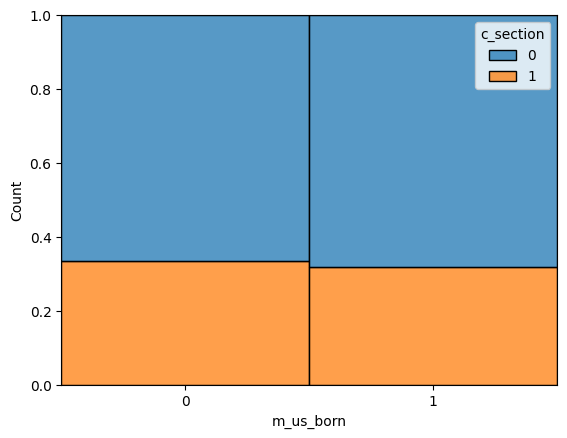

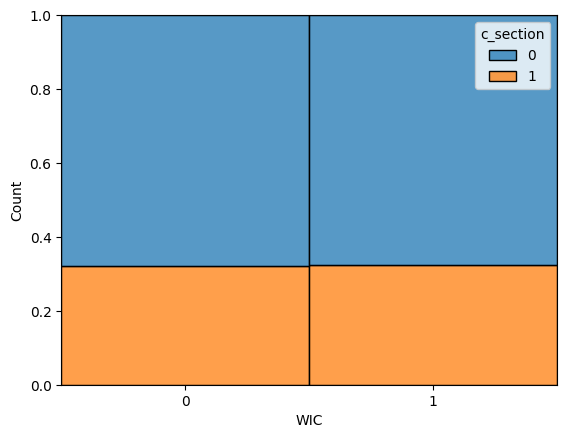

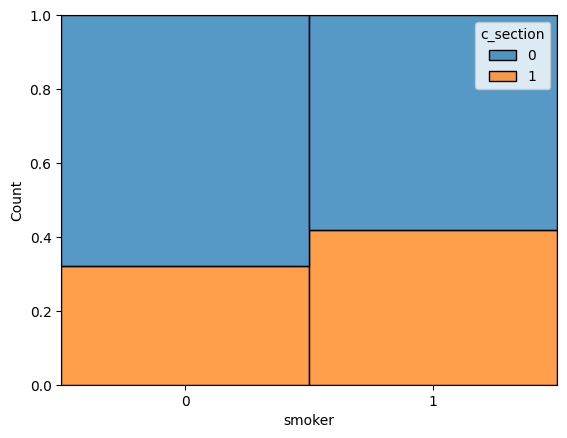

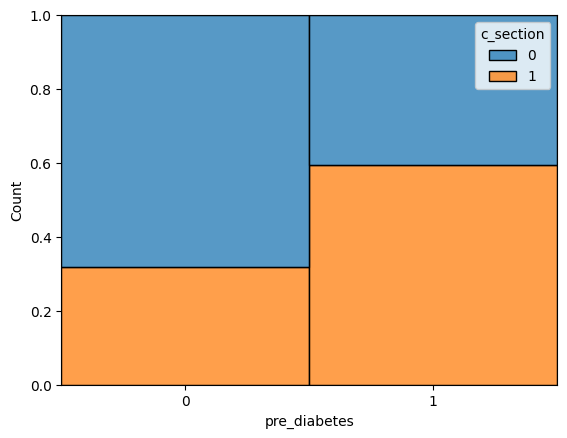

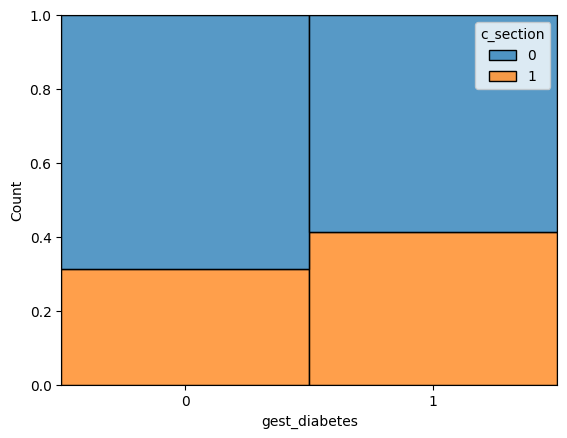

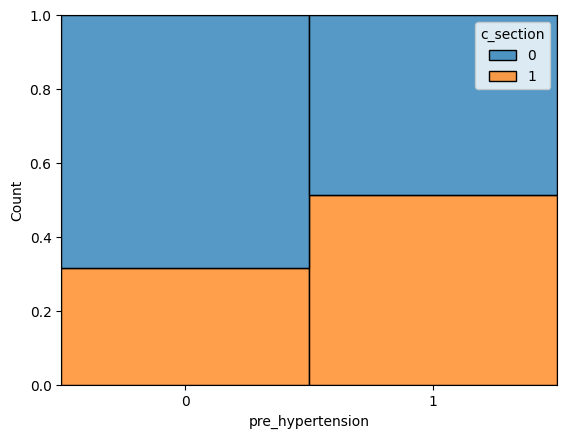

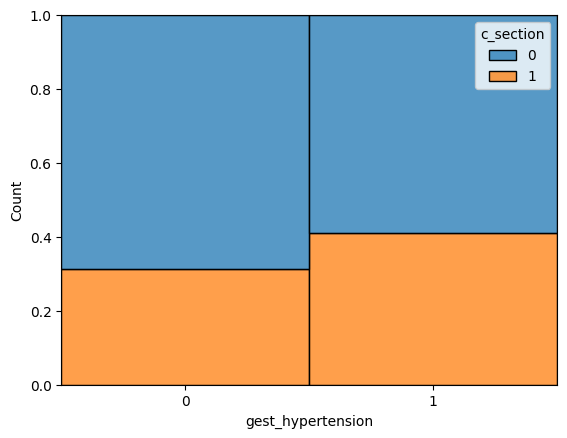

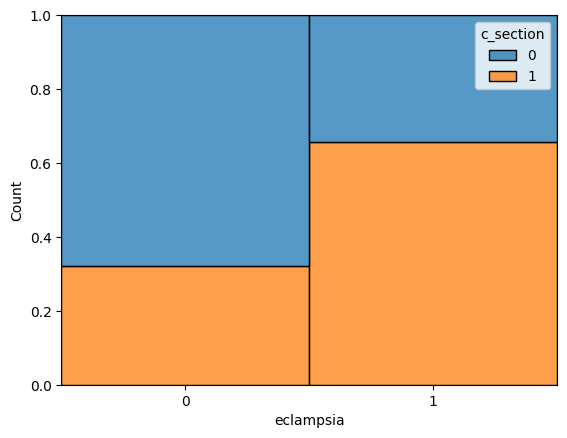

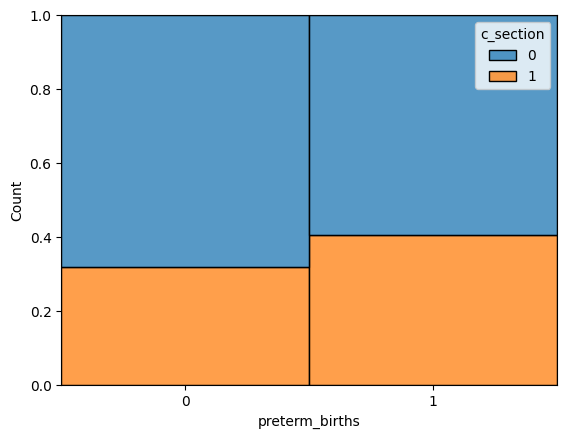

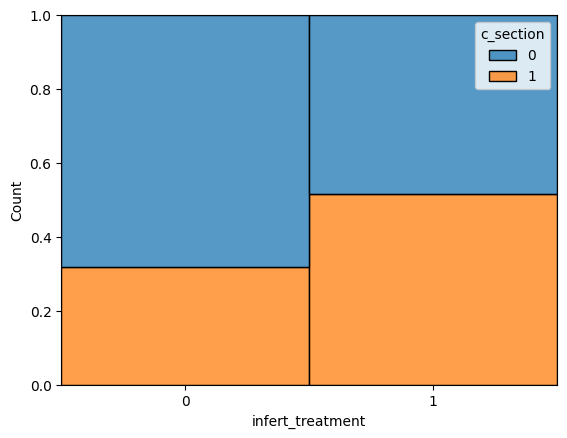

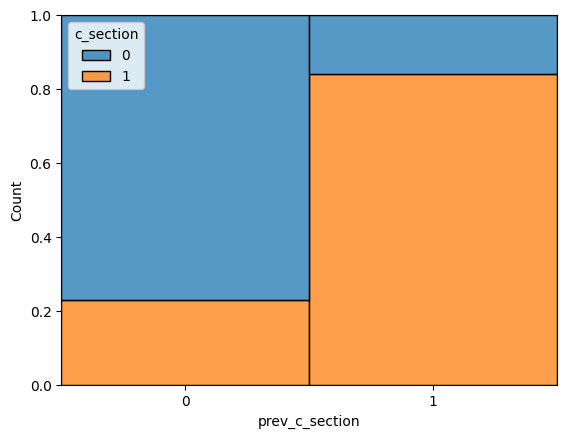

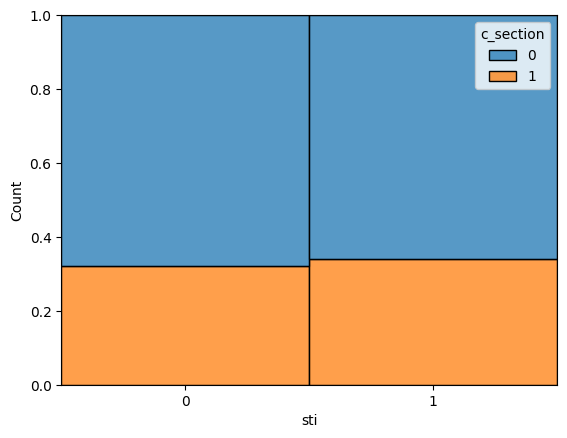

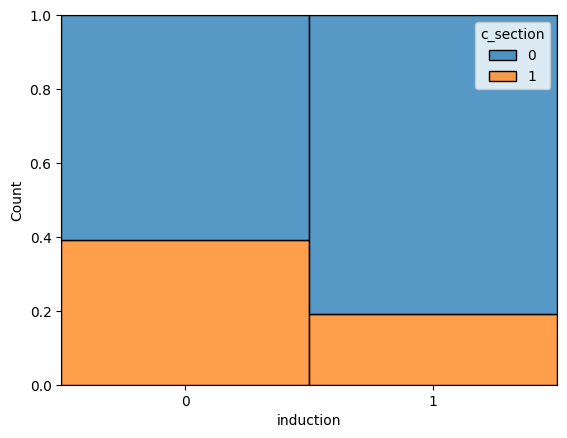

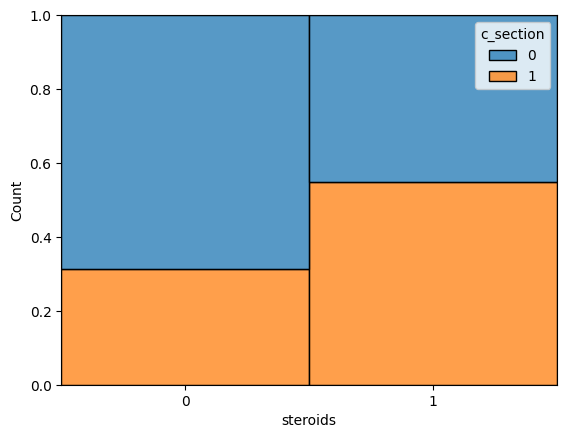

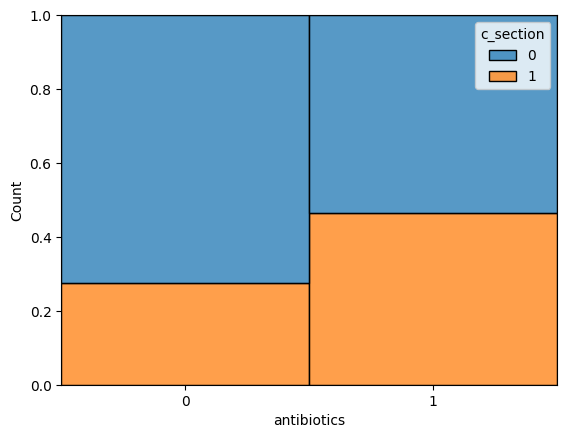

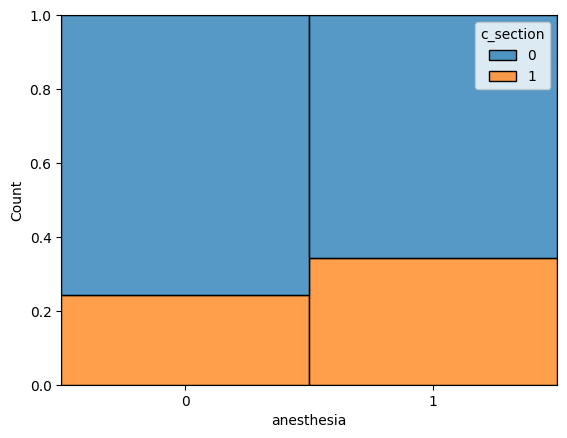

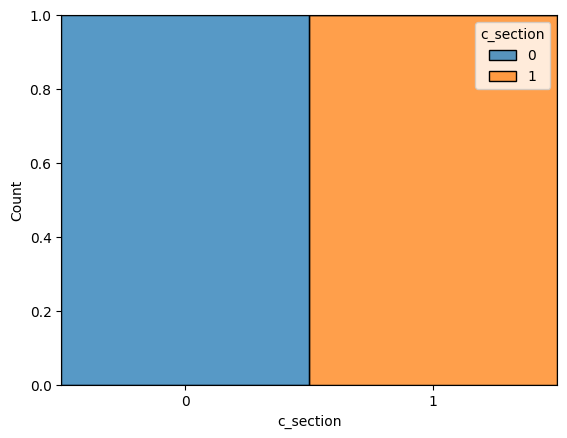

In [32]:
for i,col in enumerate(cat_cols):
    plt.figure(i)
    sns.histplot(df_sample, x=col, hue='c_section', multiple='fill', discrete=True)
    plt.xticks([0,1])